In [9]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Core libraries imported successfully!")

Core libraries imported successfully!


In [11]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check PyTorch version
print(f"PyTorch Version:{torch.__version__}")

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using Device:{device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

print("\nPyTorch is ready to use!")

PyTorch Version:2.9.0+cpu
Using Device:cpu

PyTorch is ready to use!


In [ ]:
from sklearn.datasets import fetch_california_housing

In [5]:
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target

print("California housing dataset:")
print(f"Samples:{X_housing.shape[0]}")
print(f"Features:{X_housing.shape[1]}")
print(f"\nFeature_Names:{housing.feature_names}")
print(f"\nTarget: Median house value (100k)")
print(f"Range ${y_housing.min()*100000:.0f} - ${y_housing.max()*100000:.0f}")

California housing dataset:
Samples:20640
Features:8

Feature_Names:['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target: Median house value (100k)
Range $14999 - $500001


# Prepare data

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_housing, y_housing,
                                                            test_size=0.2, random_state=42)

# Scale features
scaler_h = StandardScaler()
X_train_h = scaler_h.fit_transform(X_train_h)
X_test_h = scaler_h.transform(X_test_h)

# Convert to tensors
X_train_h_tensor = torch.FloatTensor(X_train_h)
X_test_h_tensor = torch.FloatTensor(X_test_h)
y_train_h_tensor = torch.FloatTensor(y_train_h).unsqueeze(1)
y_test_h_tensor = torch.FloatTensor(y_test_h).unsqueeze(1)

# Create datasets and loaders
train_dataset_h = TensorDataset(X_train_h_tensor, y_train_h_tensor)
test_dataset_h = TensorDataset(X_test_h_tensor, y_test_h_tensor)

train_loader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True)
test_loader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False)
print("Data prepared for regression")

Data prepared for regression


# Regression Model

In [36]:
class RegressionModel(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.fc1=nn.Linear(input_size, 64)
    #self.dropout1=nn.Dropout(0.2)
    self.fc2=nn.Linear(64, 32)
    #self.dropout2=nn.Dropout(0.2)
    self.fc3=nn.Linear(32, 16)
    self.fc4=nn.Linear(16, 1) # Single output for regression

  def forward(self, x):
    x=F.relu(self.fc1(x))
    #x=self.dropout1(x)
    x=F.relu(self.fc2(x))
    #x=self.dropout2(x)
    x=F.relu(self.fc3(x))
    x=self.fc4(x)  # No activation for regression

    return x

regression_model = RegressionModel(input_size=8).to(device)
print(regression_model)

print("\n💡 Key differences from classification:")
print("  - 1 output neuron (not multiple classes)")
print("  - No activation on output (linear)")
print("  - MSE loss (not CrossEntropy)")

RegressionModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

💡 Key differences from classification:
  - 1 output neuron (not multiple classes)
  - No activation on output (linear)
  - MSE loss (not CrossEntropy)


Setup for regression

In [37]:
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(regression_model.parameters(), lr=0.001)

print("Regression setup complete")
print(f"   Loss:MSE")
print(f"   Optimizer:Adam")

Regression setup complete
   Loss:MSE
   Optimizer:Adam


# Training functions for regression

In [38]:
def train_epoch_regression(model, dataloader, criterion, optimizer, device):
  model.train()
  running_loss = 0
  running_mae = 0
  total = 0

  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss=criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    running_mae += torch.abs(outputs - targets).sum().item()
    total += inputs.size(0)
  return running_loss/total, running_mae/total

def validate_regression(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0
  running_mae = 0
  total = 0

  with torch.no_grad():
    for inputs, targets in dataloader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      running_loss += loss.item()*inputs.size(0)
      running_mae += torch.abs(outputs - targets).sum().item()
      total += inputs.size(0)

  return running_loss/total, running_mae/total

print("✓ Training functions ready")

✓ Training functions ready


# Train Regression model

In [39]:
num_epochs = 100
train_losses_reg = []
val_losses_reg = []
train_maes_reg = []
val_maes_reg = []

print("Training regression model...")
for epoch in range(num_epochs):
  train_loss, train_mae = train_epoch_regression(
      regression_model, train_loader_h, criterion_reg, optimizer_reg, device
  )

  val_loss, val_mae = validate_regression(
      regression_model, test_loader_h, criterion_reg, device
  )

  train_losses_reg.append(train_loss)
  val_losses_reg.append(val_loss)
  train_maes_reg.append(train_mae)
  val_maes_reg.append(val_mae)

  if (epoch+1)%20 == 0:
    print(f"Epoch:[{epoch+1}/{num_epochs}]")
    print(f"     Train MSE:{train_loss:.4f}, MAE:{train_mae:.4f}")
    print(f"     Val MSE:{val_loss:.4f}, MAE:{val_mae:.4f}")
print("\n✓ Training complete!")

Training regression model...
Epoch:[20/100]
     Train MSE:0.2870, MAE:0.3689
     Val MSE:0.2957, MAE:0.3711
Epoch:[40/100]
     Train MSE:0.2571, MAE:0.3467
     Val MSE:0.2747, MAE:0.3578
Epoch:[60/100]
     Train MSE:0.2401, MAE:0.3348
     Val MSE:0.2722, MAE:0.3560
Epoch:[80/100]
     Train MSE:0.2283, MAE:0.3272
     Val MSE:0.2776, MAE:0.3611
Epoch:[100/100]
     Train MSE:0.2162, MAE:0.3178
     Val MSE:0.2667, MAE:0.3512

✓ Training complete!


Visualize Training

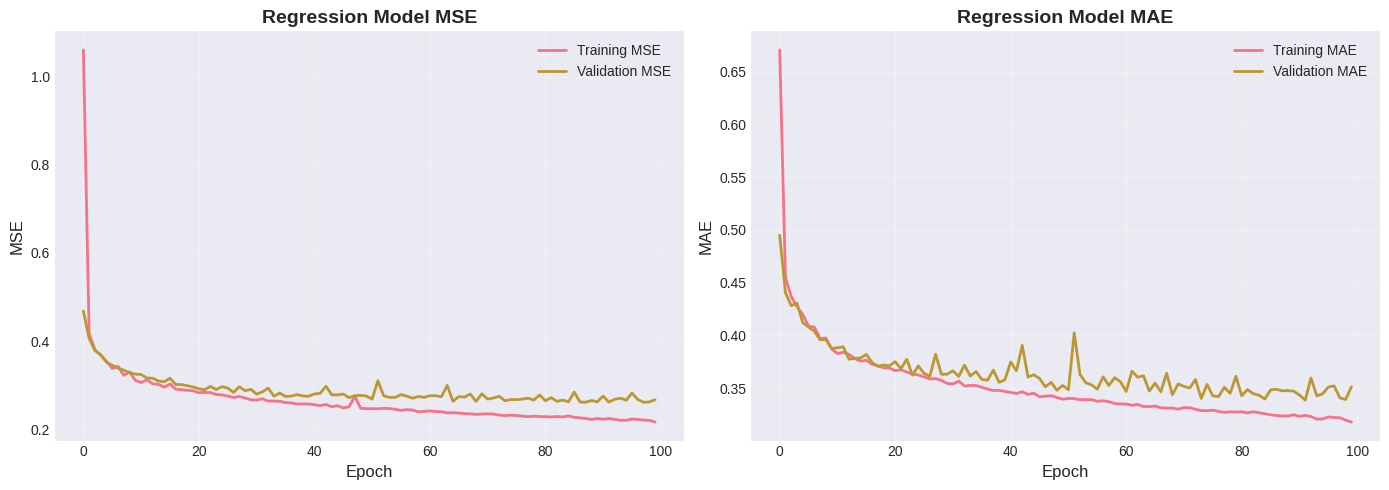

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses_reg, label='Training MSE', linewidth=2)
ax1.plot(val_losses_reg, label='Validation MSE', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE', fontsize=12)
ax1.set_title('Regression Model MSE', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_maes_reg, label='Training MAE', linewidth=2)
ax2.plot(val_maes_reg, label='Validation MAE', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('Regression Model MAE', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Make Predictions

In [44]:
regression_model.eval()
all_predictions_reg = []
all_targets_reg = []

with torch.no_grad():
  for inputs, targets in test_loader_h:
    inputs=inputs.to(device)
    outputs=regression_model(inputs)
    all_predictions_reg.extend(outputs.cpu().numpy())
    all_targets_reg.extend(targets.numpy())

all_predictions_reg = np.array(all_predictions_reg).flatten()
all_targets_reg = np.array(all_targets_reg).flatten()

# Calculate R²
from sklearn.metrics import r2_score
r2 = r2_score(all_targets_reg, all_predictions_reg)

print(f"Test MSE:{val_losses_reg[-1]:.4f}")
print(f"Test MAE:{val_maes_reg[-1]:.4f} ({val_maes_reg[-1]*100000:.0f})")
print(f"Test RMSE:{np.sqrt(val_losses_reg[-1]):.4f}")
print(f"R2_Score:{r2:.4f}")

Test MSE:0.2667
Test MAE:0.3512 (35117)
Test RMSE:0.5164
R2_Score:0.7965


Visualize Predictions

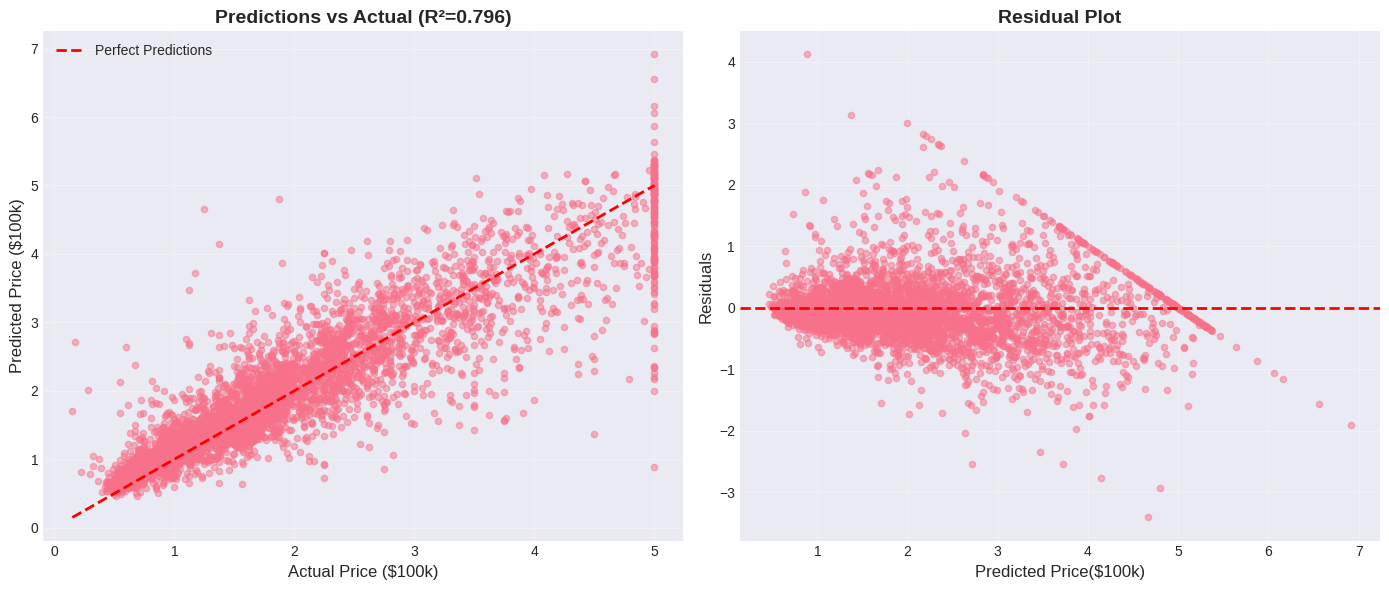

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Predictions vs Actual
ax1.scatter(all_targets_reg, all_predictions_reg, alpha=0.5, s=20)
ax1.plot([all_targets_reg.min(), all_targets_reg.max()],
         [all_targets_reg.min(), all_targets_reg.max()],
         'r--', linewidth=2, label='Perfect Predictions')
ax1.set_xlabel('Actual Price ($100k)', fontsize=12)
ax1.set_ylabel('Predicted Price ($100k)', fontsize=12)
ax1.set_title(f"Predictions vs Actual (R²={r2:.3f})", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuals
residuals = all_targets_reg - all_predictions_reg
ax2.scatter(all_predictions_reg, residuals, alpha=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Price($100k)', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()